In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from adjustText import adjust_text


In [2]:
rent_df = pd.read_csv('../data/curated/time_series_annual_rent.csv')
wealth_df = pd.read_csv('../data/curated/time_series_wealth.csv')
population_df = pd.read_csv('../data/curated/time_series_population.csv')

In [3]:
merged_df = pd.merge(rent_df, wealth_df, on='suburb')
merged_df = pd.merge(merged_df, population_df, on='suburb')
merged_df

,suburb,rent_2018,rent_2019,rent_2020,rent_2021,rent_2022,wealth_2018,wealth_2019,wealth_2020,wealth_2021,wealth_2022,pop_2018,pop_2019,pop_2020,pop_2021,pop_2022
0,Albert Park-Middle Park-West St Kilda,560,560,580,500,513,67627.0,66160.0,66627.0,67518.0,68933.0,15644.000000,15759.0,15638.000000,14104.000000,14229.000000
1,Armadale,495,480,500,440,450,64169.0,64075.0,66098.0,69563.0,72012.0,9899.000000,10036.0,10063.000000,9436.000000,9360.000000
2,Carlton North,560,577,590,575,595,54412.0,54876.0,57240.0,60116.0,60975.0,9020.000000,8988.0,8891.000000,8295.000000,8146.000000
3,Carlton-Parkville,410,440,400,340,319,46050.0,45596.0,46314.0,49544.0,47865.0,8243.000000,8294.0,8321.000000,7446.000000,7442.000000
4,CBD-St Kilda Rd,495,500,495,369,390,31242.0,28068.0,28806.0,30024.0,29908.0,15871.666667,16581.0,16808.333333,14607.666667,15582.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,Swan Hill,250,260,270,300,300,42773.0,43771.0,46178.0,47032.0,47677.0,11205.000000,11251.0,11260.000000,11169.000000,11020.000000
140,Torquay,480,500,500,550,600,47833.0,49674.0,52107.0,54955.0,56102.0,20972.000000,22116.0,23299.000000,24617.000000,25419.000000
141,Traralgon,275,285,300,340,380,50780.0,50447.0,52169.0,54079.0,55464.0,16259.000000,16489.0,16679.000000,16769.000000,16939.000000
142,Warragul,320,350,350,380,400,43536.0,44772.0,46945.0,48855.0,50654.0,21934.000000,22157.0,22379.000000,22462.000000,22548.000000


# train test split the dataset and evaluate the model performance (ARIMAX)

In [118]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

forecasts = []
maes = []  # List to store the Mean Absolute Errors for each suburb
mses = []  # List to store the Mean Squared Errors for each suburb

# Create an empty DataFrame to store the actual and predicted rental prices
rent_df = pd.DataFrame(columns=['suburb', 'actual_rent_2022', 'predicted_rent_2022'])

for index, row in merged_df.iterrows():
    suburb = row['suburb']
    
    rents = pd.to_numeric(row[['rent_2018', 'rent_2019', 'rent_2020', 'rent_2021', 'rent_2022']], errors='coerce').dropna()
    wealths = pd.to_numeric(row[['wealth_2018', 'wealth_2019', 'wealth_2020', 'wealth_2021', 'wealth_2022']], errors='coerce').dropna()
    pops = pd.to_numeric(row[['pop_2018', 'pop_2019', 'pop_2020', 'pop_2021', 'pop_2022']], errors='coerce').dropna()
    
    if rents.isnull().any() or wealths.isnull().any() or pops.isnull().any():
        print(f"Non-numeric values found in data for {suburb}, skipping...")
        continue
    
    years = pd.to_datetime(rents.index.str.split('_').str[-1])
    rent_series = pd.Series(rents.values, index=years).sort_index()
    wealth_series = pd.Series(wealths.values, index=years).sort_index()
    pop_series = pd.Series(pops.values, index=years).sort_index()

    try:
        train_rent = rent_series.loc[:'2021']
        train_wealth = wealth_series.loc[:'2021']
        train_pop = pop_series.loc[:'2021']
        
        test_rent = rent_series.loc['2022']
        
        wealth_model = ARIMA(train_wealth, order=(1, 1, 1))
        wealth_results = wealth_model.fit()
        wealth_forecast = wealth_results.get_forecast(steps=1).predicted_mean.iloc[0]
        
        pop_model = ARIMA(train_pop, order=(1, 1, 1))
        pop_results = pop_model.fit()
        pop_forecast = pop_results.get_forecast(steps=1).predicted_mean.iloc[0]
        
        train_index = train_rent.index
        exog_train = pd.DataFrame({'wealth': train_wealth.reindex(train_index, fill_value=train_wealth.mean()).values,
                                   'pop': train_pop.reindex(train_index, fill_value=train_pop.mean()).values},
                                  index=train_index)
        
        rent_model = SARIMAX(train_rent, exog=exog_train, order=(1, 1, 1))
        rent_results = rent_model.fit()
        
        test_index = pd.DatetimeIndex(['2022'])
        exog_test = pd.DataFrame({'wealth': [wealth_forecast], 'pop': [pop_forecast]}, index=test_index)
        
        rent_forecast = rent_results.get_forecast(steps=1, exog=exog_test).predicted_mean.iloc[0]
        
        rent_df = rent_df.append({'suburb': suburb,
                                  'actual_rent_2022': test_rent, 
                                  'predicted_rent_2022': rent_forecast}, 
                                 ignore_index=True)
        
        maes.append(mean_absolute_error([test_rent], [rent_forecast]))
        mses.append(mean_squared_error([test_rent], [rent_forecast]))
    except Exception as e:
        print(f"Failed to fit models for {suburb}. Error: {e}")



avg_mae = sum(maes) / len(maes)
avg_mse = sum(mses) / len(mses)



/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/huanhh/.local/lib/python3.10/site-packages/st

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23868D+00    |proj g|=  3.85769D-01

At iterate    5    f=  2.80473D+00    |proj g|=  2.56897D+01

At iterate   10    f=  2.72823D+00    |proj g|=  6.36608D+00

At iterate   15    f=  2.72341D+00    |proj g|=  3.20050D-01

At iterate   20    f=  2.71864D+00    |proj g|=  6.17082D+00

At iterate   25    f=  2.63428D+00    |proj g|=  6.89358D+00

At iterate   30    f=  2.57956D+00    |proj g|=  8.75705D+00

At iterate   35    f=  2.17306D+00    |proj g|=  1.49508D+01

At iterate   40    f=  1.58770D+00    |proj g|=  8.08928D+02

At iterate   45    f=  1.10220D+00    |proj g|=  3.94994D+02

At iterate   50    f=  9.51091D-01    |proj g|=  5.22948D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/huanhh/.local/lib/python3.10/site-packages/st


At iterate   25    f=  2.93727D+00    |proj g|=  1.45932D+01

At iterate   30    f=  2.88961D+00    |proj g|=  4.04826D-01

At iterate   35    f=  2.88904D+00    |proj g|=  4.27232D-02

At iterate   40    f=  2.88886D+00    |proj g|=  9.63993D-01

At iterate   45    f=  2.87181D+00    |proj g|=  7.00544D+00

At iterate   50    f=  2.56732D+00    |proj g|=  1.36543D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     66      1     0     0   1.365D+02   2.567D+00
  F =   2.5673176208318580     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91881D+00    |proj g|=  8.91792D-01

At iterate    5    f=  2.91166D+00    |proj g|=  3.68671D+01

At iterate   10    f=  2.86477D+00    |proj g|=  5.04882D+01

At iterate   15    f=  2.55397D+00    |proj g|=  1.89361D+02

At iterate   20    f=  2.16496D+00    |proj g|=  3.46860D+00

At iterate   25    f=  2.16447D+00    |proj g|=  9.12176D-01

At iterate   30    f=  2.16011D+00    |proj g|=  1.36801D+01

At iterate   35    f=  1.96213D+00    |proj g|=  2.31622D+02

At iterate   40    f=  1.78263D+00    |proj g|=  2.53561D+01

At iterate   45    f=  1.46579D+00    |proj g|=  8.04875D+01

At iterate   50    f=  1.12191D+00    |proj g|=  1.75393D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rent_df = rent_df.append({'suburb': suburb,
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency informa


At iterate   35    f=  1.46760D+00    |proj g|=  1.24375D+03

At iterate   40    f=  1.01628D+00    |proj g|=  1.77201D+03

At iterate   45    f=  8.71724D-01    |proj g|=  2.63896D+02

At iterate   50    f=  6.42421D-01    |proj g|=  1.24790D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     79      1     0     0   1.248D+03   6.424D-01
  F =  0.64242106138816046     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.28561D+00    |proj g|=  3.65503D+00

At iterate    5    f=  3.77469D+00    |proj g|=  2.82241D+01

At iterate   10    f=  3.44272D+00    |proj g|=  1.21638D+00

At iterate   15    f=  3.44190D+00    |proj g|=  7.96811D-02

At iterate   20    f=  3.42761D+00    |proj g|=  2.80166D+00

At iterate   25    f=  3.31134D+00    |proj g|=  4.03658D+00

At iterate   30    f=  3.29109D+00    |proj g|=  6.99882D+00

At iterate   35    f=  3.22834D+00    |proj g|=  3.90285D+01

At iterate   40    f=  2.66145D+00    |proj g|=  4.39118D+02

At iterate   45    f=  2.03161D+00    |proj g|=  1.38364D+03

At iterate   50    f=  1.60532D+00    |proj g|=  2.33369D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rent_df = rent_df.append({'suburb': suburb,
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency informa


At iterate   45    f=  2.36205D+00    |proj g|=  1.63168D+02

At iterate   50    f=  1.09977D+00    |proj g|=  9.15804D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     82      1     0     0   9.158D+02   1.100D+00
  F =   1.0997704370794190     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.45028D+00    |proj g|=  1.07109D+00

At iterate    5    f=  2.45026D+00    |proj g|=  3.87344D+00

At iter

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/huanhh/.local/lib/python3.10/site-packages/st

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.06151D+00    |proj g|=  1.54031D-01

At iterate    5    f=  3.06151D+00    |proj g|=  9.39784D-02

At iterate   10    f=  3.06150D+00    |proj g|=  1.10879D+00

At iterate   15    f=  3.06115D+00    |proj g|=  3.20294D+00

At iterate   20    f=  2.99526D+00    |proj g|=  5.88136D+01

At iterate   25    f=  2.83014D+00    |proj g|=  2.03792D+00

At iterate   30    f=  2.82822D+00    |proj g|=  1.87642D-01

At iterate   35    f=  2.82787D+00    |proj g|=  3.64346D+00

At iterate   40    f=  2.74088D+00    |proj g|=  2.32575D+01

At iterate   45    f=  2.47514D+00    |proj g|=  2.59996D+01

At iterate   50    f=  1.78182D+00    |proj g|=  4.50914D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rent_df = rent_df.append({'suburb': suburb,
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency informa


At iterate   30    f=  3.08648D+00    |proj g|=  7.55059D-01

At iterate   35    f=  3.08375D+00    |proj g|=  1.22652D+01

At iterate   40    f=  2.91314D+00    |proj g|=  2.43266D+02

At iterate   45    f=  2.55822D+00    |proj g|=  1.56543D+03

At iterate   50    f=  2.24043D+00    |proj g|=  3.78355D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     72      1     0     0   3.784D+01   2.240D+00
  F =   2.2404252819017980     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observat


At iterate   45    f=  1.45708D+00    |proj g|=  9.92276D+02

At iterate   50    f=  9.55875D-01    |proj g|=  8.32555D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     81      1     0     0   8.326D+02   9.559D-01
  F =  0.95587503548453534     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54584D+00    |proj g|=  7.37956D+00

           * * *

Tit   = total number of iterations
Tnf   = total nu

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     21      1     0     0   5.981D+00   4.261D+00
  F =   4.2613959182748475     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66507D+00    |proj g|=  2.69777D+00

At iterate    5    f=  1.66507D+00    |proj g|=  6.76407D-01

At iterate   10    f=  1.66506D+00    |proj g|=  4.14985D+00

At iterate   15    f=  1.66481D+00    |proj g|=  3.34892D+00

At iter

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     63      1     0     0   4.961D+00   1.412D+00
  F =   1.4124850396190229     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52114D+00    |proj g|=  2.60132D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/hom

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85464D+00    |proj g|=  5.31140D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3     24      1     0     0   4.793D+00   1.855D+00
  F =   1.8546388472308064     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.7

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/huanhh/.local/lib/python3.10/site-packages/st

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.20189D-01    |proj g|=  1.08060D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     18      1     0     0   1.081D+02   7.202D-01
  F =  0.72018872790221933     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.0

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

   

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.36727D+00    |proj g|=  3.31173D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     13      1     0     0   3.248D+00   2.367D+00
  F =   2.3672660403392363     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.0

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rent_df = rent_df.append({'suburb': suburb,
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency informa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.53139D+00    |proj g|=  5.28072D-01

At iterate    5    f=  2.52774D+00    |proj g|=  1.58703D+01

At iterate   10    f=  2.29549D+00    |proj g|=  8.66862D+01

At iterate   15    f=  2.22054D+00    |proj g|=  1.52458D-01

At iterate   20    f=  2.22024D+00    |proj g|=  6.24528D-01

At iterate   25    f=  2.19461D+00    |proj g|=  3.59878D+00

At iterate   30    f=  1.75847D+00    |proj g|=  1.97775D+02

At iterate   35    f=  1.14349D+00    |proj g|=  4.69083D+02

At iterate   40    f=  9.39170D-01    |proj g|=  2.93454D+02

At iterate   45    f=  5.83106D-01    |proj g|=  3.97924D+02

At iterate   50    f=  1.76272D-01    |proj g|=  8.30040D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp


At iterate    5    f=  5.00470D+00    |proj g|=  3.30566D+02

At iterate   10    f=  2.42462D+00    |proj g|=  4.55692D+01

At iterate   15    f=  2.37939D+00    |proj g|=  9.27280D-02

At iterate   20    f=  2.37922D+00    |proj g|=  1.39721D+00

At iterate   25    f=  2.35575D+00    |proj g|=  2.08699D+01

At iterate   30    f=  1.74565D+00    |proj g|=  3.77857D+02

At iterate   35    f=  1.57597D+00    |proj g|=  2.43076D+02

At iterate   40    f=  1.11993D+00    |proj g|=  3.92864D+02

At iterate   45    f=  7.43909D-01    |proj g|=  1.45906D+03

At iterate   50    f=  2.47879D-01    |proj g|=  2.00827D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rent_df = rent_df.append({'suburb': suburb,
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency informa


At iterate   50    f=  5.32866D-01    |proj g|=  6.60526D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     64      1     0     0   6.605D+02   5.329D-01
  F =  0.53286564905616984     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.18731D+00    |proj g|=  6.34321D-01

At iterate    5    f=  2.18579D+00    |proj g|=  1.74836D+01

At iterate   10    f=  2.05491D+00    |proj g|=  5.29350D+01

At iter

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/huanhh/.local/lib/python3.10/site-packages/st

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.73642D+00    |proj g|=  3.59335D-01

At iterate    5    f=  2.73357D+00    |proj g|=  1.31699D+01

At iterate   10    f=  2.66480D+00    |proj g|=  3.42753D+01

At iterate   15    f=  2.47102D+00    |proj g|=  2.84681D+00

At iterate   20    f=  2.47006D+00    |proj g|=  9.39890D-01

At iterate   25    f=  2.38784D+00    |proj g|=  2.25269D+00

At iterate   30    f=  2.38020D+00    |proj g|=  3.98584D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rent_df = rent_df.append({'suburb': suburb,
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred fr


At iterate   50    f= -2.52346D-01    |proj g|=  1.85550D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     65      1     0     0   1.856D+03  -2.523D-01
  F = -0.25234590092611098     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18162D+00    |proj g|=  4.64060D+00

At iterate    5    f=  1.18162D+00    |proj g|=  4.23293D+00

           * * *

Tit   = total number of iterations
Tnf   = total nu

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/huanhh/.local/lib/python3.10/site-packages/st

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36270D+00    |proj g|=  3.00107D+00

At iterate    5    f=  1.36270D+00    |proj g|=  1.06350D+00

At iterate   10    f=  1.36269D+00    |proj g|=  2.07760D+00

At iterate   15    f=  1.36267D+00    |proj g|=  1.13663D+01

At iterate   20    f=  1.36127D+00    |proj g|=  2.44137D+01

At iterate   25    f=  1.29474D+00    |proj g|=  2.44088D+02

At iterate   30    f=  1.14082D+00    |proj g|=  1.03056D+01

At iterate   35    f=  1.13905D+00    |proj g|=  2.40709D+01

At iterate   40    f=  9.68240D-01    |proj g|=  6.88810D+02

At iterate   45    f=  5.97589D-01    |proj g|=  6.44835D+01

At iterate   50    f=  2.25379D-01    |proj g|=  5.51518D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rent_df = rent_df.append({'suburb': suburb,
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency informa


At iterate   40    f=  9.92034D-01    |proj g|=  7.52960D+01

At iterate   45    f=  6.83414D-01    |proj g|=  6.37239D+02

At iterate   50    f=  1.38892D-01    |proj g|=  2.35752D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     70      1     0     0   2.358D+03   1.389D-01
  F =  0.13889172212652129     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39379D+00    |proj g|=  7.51177D-01

At iter

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/huanhh/.local/lib/python3.10/site-packages/st


At iterate   40    f=  9.50532D-01    |proj g|=  5.61325D+01

At iterate   45    f=  5.78846D-01    |proj g|=  5.64839D+02

At iterate   50    f=  1.52331D-01    |proj g|=  1.59553D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     85      1     0     0   1.596D+03   1.523D-01
  F =  0.15233107739203033     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97075D+00    |proj g|=  2.88551D-01

At iter

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11595D+00    |proj g|=  2.16645D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     14      1     0     0   2.164D+01   1.116D+00
  F =   1.1159472976303073     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.2

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rent_df = rent_df.append({'suburb': suburb,
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency informa


At iterate   50    f=  8.34314D-01    |proj g|=  6.83529D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     85      1     0     0   6.835D+02   8.343D-01
  F =  0.83431440606648966     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11438D+00    |proj g|=  4.91160D-01

At iterate    5    f=  2.11306D+00    |proj g|=  1.24128D+01

At iterate   10    f=  2.01208D+00    |proj g|=  6.48787D+01

At iter

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/huanhh/.local/lib/python3.10/site-packages/st

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.96994D+00    |proj g|=  6.50342D-01

At iterate    5    f=  1.96953D+00    |proj g|=  9.46232D+00

At iterate   10    f=  1.94350D+00    |proj g|=  4.82981D+01

At iterate   15    f=  1.71691D+00    |proj g|=  1.90142D+01

At iterate   20    f=  1.71398D+00    |proj g|=  9.48108D-01

At iterate   25    f=  1.71132D+00    |proj g|=  6.85806D+00

At iterate   30    f=  1.32419D+00    |proj g|=  2.87492D+02

At iterate   35    f=  9.21482D-01    |proj g|=  1.06694D+03

At iterate   40    f=  8.80607D-01    |proj g|=  3.00578D+02

At iterate   45    f=  5.12636D-01    |proj g|=  2.05216D+02

At iterate   50    f=  1.82972D-01    |proj g|=  5.31699D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rent_df = rent_df.append({'suburb': suburb,
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency informa


At iterate   50    f=  1.46501D+00    |proj g|=  8.18662D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     92      2     0     0   8.187D+00   1.465D+00
  F =   1.4650142872397161     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.40838D+00    |proj g|=  4.26287D-02

At iterate    5    f=  3.40824D+00    |proj g|=  1.08437D-01

At iterate   10    f=  3.40629D+00    |proj g|=  5.13378D+00

At iter

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observat


At iterate   50    f=  1.59336D+00    |proj g|=  3.84991D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     86      1     0     0   3.850D+01   1.593D+00
  F =   1.5933631195024298     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.41035D+00    |proj g|=  4.38811D-01

At iterate    5    f=  3.16565D+00    |proj g|=  2.02175D+00

At iterate   10    f=  3.16479D+00    |proj g|=  3.14482D-02

At iter

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/huanhh/.local/lib/python3.10/site-packages/st

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20047D+00    |proj g|=  3.58822D-01

At iterate    5    f=  2.19988D+00    |proj g|=  2.70653D+00

At iterate   10    f=  2.06038D+00    |proj g|=  1.08479D+02

At iterate   15    f=  1.88745D+00    |proj g|=  1.56421D-01

At iterate   20    f=  1.87385D+00    |proj g|=  8.39273D+00

At iterate   25    f=  1.56224D+00    |proj g|=  7.50485D+01

At iterate   30    f=  1.11504D+00    |proj g|=  5.65254D+02

At iterate   35    f=  8.14215D-01    |proj g|=  6.74338D+02

At iterate   40    f=  3.63560D-01    |proj g|=  1.32569D+03

At iterate   45    f=  6.22334D-02    |proj g|=  1.88341D+03

At iterate   50    f= -1.43232D-01    |proj g|=  5.68699D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rent_df = rent_df.append({'suburb': suburb,
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency informa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02543D+00    |proj g|=  9.59923D-01

At iterate    5    f=  2.02526D+00    |proj g|=  7.14577D+00

At iterate   10    f=  2.00563D+00    |proj g|=  4.95229D+01

At iterate   15    f=  1.76623D+00    |proj g|=  1.91630D+01

At iterate   20    f=  1.76462D+00    |proj g|=  3.51428D+00

At iterate   25    f=  1.73366D+00    |proj g|=  8.79418D+01

At iterate   30    f=  9.20345D-01    |proj g|=  1.52462D+02

At iterate   35    f=  7.15380D-01    |proj g|=  7.12783D+02

At iterate   40    f=  2.10752D-01    |proj g|=  1.87607D+03

At iterate   45    f= -2.59372D-01    |proj g|=  3.15303D+03
  ys=-1.125E-10  -gs= 4.720E-09 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy search


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rent_df = rent_df.append({'suburb': suburb,
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90864D-01    |proj g|=  2.68439D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     21      1     0     0   2.684D+02   1.909D-01
  F =  0.19086420772558452     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.7

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29170D+00    |proj g|=  4.82915D-01

At iterate    5    f=  3.08639D+00    |proj g|=  3.93542D+00

At iterate   10    f=  3.03020D+00    |proj g|=  7.93598D-02

At iterate   15    f=  3.02993D+00    |proj g|=  1.74425D+00

At iterate   20    f=  2.99998D+00    |proj g|=  5.23690D+00

At iterate   25    f=  2.98526D+00    |proj g|=  8.27271D-01

At iterate   30    f=  2.98375D+00    |proj g|=  3.39622D-01

At iterate   35    f=  2.98334D+00    |proj g|=  7.13936D-01

At iterate   40    f=  2.94685D+00    |proj g|=  5.05819D+00

At iterate   45    f=  2.26486D+00    |proj g|=  3.67941D+02

At iterate   50    f=  1.58111D+00    |proj g|=  2.18448D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rent_df = rent_df.append({'suburb': suburb,
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency informa


At iterate   40    f=  2.35464D+00    |proj g|=  2.45838D+03

At iterate   45    f=  1.71063D+00    |proj g|=  1.91622D+02

At iterate   50    f=  1.63859D+00    |proj g|=  7.54407D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     76      1     0     0   7.544D+01   1.639D+00
  F =   1.6385901428695977     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31727D+00    |proj g|=  5.84447D-01

At iter

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58658D+00    |proj g|=  6.48275D-01

At iterate    5    f=  2.58341D+00    |proj g|=  2.01429D+01

At iterate   10    f=  2.41693D+00    |proj g|=  5.06720D+01

At iterate   15    f=  2.31694D+00    |proj g|=  7.33956D-01

At iterate   20    f=  2.31661D+00    |proj g|=  7.51529D-01

At iterate   25    f=  2.30331D+00    |proj g|=  8.53908D+00

At iterate   30    f=  1.87325D+00    |proj g|=  7.67413D+02

At iterate   35    f=  1.38240D+00    |proj g|=  1.45206D+03

At iterate   40    f=  1.01613D+00    |proj g|=  4.54426D+02

At iterate   45    f=  7.96485D-01    |proj g|=  5.30248D+03

At iterate   50    f=  4.55265D-01    |proj g|=  3.66464D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rent_df = rent_df.append({'suburb': suburb,
/home/huanhh/.local/

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.65026D+00    |proj g|=  1.67356D-01

At iterate    5    f=  2.64888D+00    |proj g|=  6.34835D+00

At iterate   10    f=  2.55070D+00    |proj g|=  1.97853D+01

At iterate   15    f=  2.41269D+00    |proj g|=  7.68229D-01

At iterate   20    f=  2.41268D+00    |proj g|=  5.81507D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     32      1     0     0   5.816D-02   2.413D+00
  F =   2.4126814064084381     

CONVERG

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observat

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64382D+00    |proj g|=  4.33441D+00

At iterate    5    f=  1.64382D+00    |proj g|=  3.46761D+00

At iterate   10    f=  1.64382D+00    |proj g|=  2.39194D+00

At iterate   15    f=  1.64382D+00    |proj g|=  7.75692D-01

At iterate   20    f=  1.64382D+00    |proj g|=  3.06658D+00

At iterate   25    f=  1.64197D+00    |proj g|=  4.13584D+01

At iterate   30    f=  1.52626D+00    |proj g|=  3.27666D+02

At iterate   35    f=  1.40745D+00    |proj g|=  2.38287D-01

At iterate   40    f=  1.40415D+00    |proj g|=  1.45622D+01

At iterate   45    f=  1.18029D+00    |proj g|=  1.17345D+03


/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rent_df = rent_df.append({'suburb': suburb,
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency informa


At iterate   50    f=  7.37037D-01    |proj g|=  4.63865D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50    187      1     0     0   4.639D+03   7.370D-01
  F =  0.73703734484048933     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.62231D+00    |proj g|=  6.79356D-01

At iterate    5    f=  2.61235D+00    |proj g|=  2.95122D+01

At iterate   10    f=  2.36846D+00    |proj g|=  9.43992D+00

At iter

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/huanhh/.local/lib/python3.10/site-packages/st

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09358D+00    |proj g|=  9.46055D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     12      1     0     0   9.357D+00   1.094D+00
  F =   1.0935787414847735     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.2

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rent_df = rent_df.append({'suburb': suburb,
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency informa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.36317D+00    |proj g|=  6.46635D-01

At iterate    5    f=  2.27710D+00    |proj g|=  4.52760D+01

At iterate   10    f=  2.17924D+00    |proj g|=  3.27311D+01

At iterate   15    f=  2.09305D+00    |proj g|=  6.25246D-01

At iterate   20    f=  2.09255D+00    |proj g|=  4.21932D+00

At iterate   25    f=  2.03079D+00    |proj g|=  6.51167D+01

At iterate   30    f=  1.74893D+00    |proj g|=  3.22699D+01

At iterate   35    f=  1.47499D+00    |proj g|=  1.57661D+02

At iterate   40    f=  1.14578D+00    |proj g|=  1.18570D+02

At iterate   45    f=  9.58457D-01    |proj g|=  1.71449D+02

At iterate   50    f=  6.66115D-01    |proj g|=  1.41852D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rent_df = rent_df.append({'suburb': suburb,
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency informa


At iterate   20    f=  1.79745D+00    |proj g|=  3.00542D+00

At iterate   25    f=  1.76811D+00    |proj g|=  1.23635D+02

At iterate   30    f=  1.41753D+00    |proj g|=  3.80536D+02

At iterate   35    f=  9.42263D-01    |proj g|=  2.06175D+02

At iterate   40    f=  9.21149D-01    |proj g|=  1.53904D+02

At iterate   45    f=  4.99525D-01    |proj g|=  4.37252D+03

At iterate   50    f=  3.24295D-01    |proj g|=  1.96432D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     75      1     0     0   1.964D+03   3.243D-01
  F =  0.32429539243408895     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/huanhh/.local/lib/python3.10/site-packages/st


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     18      1     0     0   3.596D+02  -1.985D-01
  F = -0.19854775530907637     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92278D+00    |proj g|=  9.65612D-01

At iterate    5    f=  1.92254D+00    |proj g|=  9.54043D+00

At iterate   10    f=  1.91601D+00    |proj g|=  3.36864D+01

At iterate   15    f=  1.74657D+00    |proj g|=  1.32081D+02

At iter

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/tmp

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.93300D+00    |proj g|=  4.91388D-01

At iterate    5    f=  2.90778D+00    |proj g|=  3.32802D+01

At iterate   10    f=  2.66251D+00    |proj g|=  6.55123D+00

At iterate   15    f=  2.66096D+00    |proj g|=  2.87790D-01

At iterate   20    f=  2.64822D+00    |proj g|=  1.82372D+01

At iterate   25    f=  2.50386D+00    |proj g|=  6.58788D+00

At iterate   30    f=  2.24590D+00    |proj g|=  2.35502D+02
  ys=-3.467E-02  -gs= 5.715E-01 BFGS update SKIPPED

At iterate   35    f=  1.17199D+00    |proj g|=  2.11511D+02

At iterate   40    f=  9.90189D-01    |proj g|=  1.23098D+03

At iterate   45    f=  8.49604D-01    |proj g|=  8.86357D+02

At iterate   50    f=  3.50903D-01    |proj g|=  1.13457D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rent_df = rent_df.append({'suburb': suburb,
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency informa


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     27      1     0     0   6.653D-02   2.412D+00
  F =   2.4121607463426926     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16569D+00    |proj g|=  1.86741D+00

At iterate    5    f=  2.16569D+00    |proj g|=  5.61454D-01

At iterate   10    f=  2.16533D+00    |proj g|=  1.76062D+01

At iterate   15    f=  2.15262D+00    |proj g|=  7.02585D+00

At iter

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rent_df = rent_df.append({'suburb': suburb,
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency informa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.07263D+00    |proj g|=  4.30588D+00

At iterate    5    f=  3.91603D+00    |proj g|=  1.89560D+02

At iterate   10    f=  1.65559D+00    |proj g|=  1.86011D+01

At iterate   15    f=  1.61374D+00    |proj g|=  1.04083D+01

At iterate   20    f=  1.61097D+00    |proj g|=  3.84096D+00

At iterate   25    f=  1.41788D+00    |proj g|=  2.59074D+02

At iterate   30    f=  1.13920D+00    |proj g|=  1.06524D+03

At iterate   35    f=  9.18722D-01    |proj g|=  4.07641D+02

At iterate   40    f=  4.99503D-01    |proj g|=  1.10428D+03

At iterate   45    f=  1.07333D-01    |proj g|=  2.12861D+03

At iterate   50    f= -1.77808D-01    |proj g|=  3.84388D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/huanhh/.local/lib/python3.10/site-packages/st

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83099D+00    |proj g|=  6.25195D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1      8      1     0     0   5.544D-01   2.831D+00
  F =   2.8309936922723238     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.7

/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rent_df = rent_df.append({'suburb': suburb,
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58723D+00    |proj g|=  3.84698D-01

At iterate    5    f=  2.53654D+00    |proj g|=  2.22332D+01

At iterate   10    f=  2.39620D+00    |proj g|=  2.10744D+00

At iterate   15    f=  2.30044D+00    |proj g|=  7.61566D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     34      1     0     0   3.481D-01   2.300D+00
  F =   2.3002483287965720     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp


At iterate   20    f=  2.94974D+00    |proj g|=  5.68058D-01

At iterate   25    f=  2.94834D+00    |proj g|=  1.12626D+01

At iterate   30    f=  2.91811D+00    |proj g|=  6.67198D+00

At iterate   35    f=  2.88499D+00    |proj g|=  1.88064D+00

At iterate   40    f=  2.78038D+00    |proj g|=  6.67458D+01

At iterate   45    f=  2.18304D+00    |proj g|=  7.32569D+02

At iterate   50    f=  1.62164D+00    |proj g|=  6.86634D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     75      1     0     0   6.866D+00   1.622D+00
  F =   1.6216436318181706     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observat

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.81143D+00    |proj g|=  1.16863D+00

At iterate    5    f=  1.81135D+00    |proj g|=  6.05886D+00

At iterate   10    f=  1.80081D+00    |proj g|=  5.67568D+01

At iterate   15    f=  1.57664D+00    |proj g|=  1.24307D+01

At iterate   20    f=  1.56832D+00    |proj g|=  1.42983D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     34      1     0     0   1.430D+00   1.568D+00
  F =   1.5683210886174059     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rent_df = rent_df.append({'suburb': suburb,
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90294D+00    |proj g|=  5.13623D-01

At iterate    5    f=  2.87502D+00    |proj g|=  3.31949D+01

At iterate   10    f=  2.64837D+00    |proj g|=  7.15710D-01

At iterate   15    f=  2.64788D+00    |proj g|=  1.60884D-01

At iterate   20    f=  2.64768D+00    |proj g|=  3.15180D+00

At iterate   25    f=  2.62637D+00    |proj g|=  2.89610D+01

At iterate   30    f=  2.57818D+00    |proj g|=  1.48215D+00

At iterate   35    f=  2.31882D+00    |proj g|=  2.12453D+00

At iterate   40    f=  1.64951D+00    |proj g|=  7.15029D+01

At iterate   45    f=  1.03844D+00    |proj g|=  4.09447D+02

At iterate   50    f=  9.68360D-01    |proj g|=  1.74083D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rent_df = rent_df.append({'suburb': suburb,
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency informa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64671D+00    |proj g|=  5.66402D-01

At iterate    5    f=  2.64507D+00    |proj g|=  1.48320D+01

At iterate   10    f=  2.51712D+00    |proj g|=  9.93846D+01

At iterate   15    f=  2.41387D+00    |proj g|=  1.50007D+01

At iterate   20    f=  2.38363D+00    |proj g|=  1.73835D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     31      1     0     0   1.662D-01   2.384D+00
  F =   2.3836346773758859     

CONVERG

/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rent_df = rent_df.append({'suburb': suburb,
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11101D+00    |proj g|=  7.09464D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     21      1     0     0   7.095D+01   1.111D+00
  F =   1.1110084452760429     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.2

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rent_df = rent_df.append({'suburb': suburb,
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency informa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25939D+00    |proj g|=  4.92775D-01

At iterate    5    f=  3.10814D+00    |proj g|=  3.24373D+01

At iterate   10    f=  3.00503D+00    |proj g|=  4.03276D-02

At iterate   15    f=  3.00464D+00    |proj g|=  2.56878D+00

At iterate   20    f=  2.96828D+00    |proj g|=  7.04230D+00

At iterate   25    f=  2.95779D+00    |proj g|=  5.55788D-01

At iterate   30    f=  2.95744D+00    |proj g|=  6.60254D-02

At iterate   35    f=  2.94596D+00    |proj g|=  7.84673D+00

At iterate   40    f=  2.77652D+00    |proj g|=  6.14071D+01

At iterate   45    f=  1.96647D+00    |proj g|=  3.13577D+02

At iterate   50    f=  1.59088D+00    |proj g|=  1.20357D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observat

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.38877D+00    |proj g|=  7.12952D-01

At iterate    5    f=  2.38749D+00    |proj g|=  1.59848D+01

At iterate   10    f=  2.27474D+00    |proj g|=  1.27974D+02

At iterate   15    f=  2.14892D+00    |proj g|=  5.04102D+01

At iterate   20    f=  2.10325D+00    |proj g|=  3.17990D-01

At iterate   25    f=  2.10269D+00    |proj g|=  4.39274D+00

At iterate   30    f=  2.02985D+00    |proj g|=  1.14832D+02

At iterate   35    f=  1.62161D+00    |proj g|=  1.13071D+02

At iterate   40    f=  1.19509D+00    |proj g|=  2.87203D+02

At iterate   45    f=  9.46872D-01    |proj g|=  2.50816D+01

At iterate   50    f=  5.48035D-01    |proj g|=  5.44336D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observat

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59125D+00    |proj g|=  7.78009D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     12      1     0     0   7.697D+00   1.591D+00
  F =   1.5912510187530331     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.8

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_635/230188899.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rent_df = rent_df.append({'suburb': suburb,
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency informa


At iterate   50    f=  1.01664D+00    |proj g|=  2.07134D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     78      1     0     0   2.071D+02   1.017D+00
  F =   1.0166359972037482     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.86333D+00    |proj g|=  1.39217D+00

At iterate    5    f=  1.86331D+00    |proj g|=  4.08017D+00

At iterate   10    f=  1.85885D+00    |proj g|=  2.40902D+01

At iter

KeyboardInterrupt: 

In [108]:
rent_results.summary()

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/mlemodel.py:3159: UserWarning: Early subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/mlemodel.py:3159: UserWarning: Later subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                    5
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -14.579
Date:                Mon, 02 Oct 2023   AIC                             39.158
Time:                        23:24:07   BIC                             36.089
Sample:                    01-01-2018   HQIC                            32.424
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
wealth        -0.0017      0.205     -0.008      0.994      -0.403       0.400
pop           -0.1489      0.989     -0.151      0.880      -2.088       1.790
ar.L1      -4.559e-08     11.895  -3.83e-09      1.000     -23.313      23.313
ma.L1       -4.56e-08     11.896  -3.83e-09      1.000     -23.315      23.315
sigma2        85.4198    202.358      0.422      0.673    -311.195     482.035
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.25
Prob(Q):                              0.89   Prob(JB):                         0.88
Heteroskedasticity (H):                nan   Skew:                             0.31
Prob(H) (two-sided):                   nan   Kurtosis:                         1.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.21e+19. Standard errors may be unstable.
"""

# eliminating the exdogenous variable (ARIMA)

In [9]:
def arima_model(param1, param2, param3):
#This function is to build ARIMA model with different parameters
    
#Parameters:
#param1(int): an int serve as a paramenter in arima_model
#param2(int): an int serve as a paramenter in arima_model
#param3(int): an int serve as a paramenter in arima_model

#Returns:
#rent_results: the output of arima model with specific paramters
#rent_df: a dataframe which contains column 'suburb', which is the suburb name in VIC,
#column 'actual_rent_2022' which is the actual rent price in that year,
#column 'predicted_rent_2022' which is the predicted rent price in that year,
#avg_mae and avg_mse are the evaluation of the arima model


    # List to store the Mean Absolute Errors for each suburb
    maes = []  

    # List to store the Mean Squared Errors for each suburb
    mses = []  

    # Create an empty DataFrame to store the actual and predicted rental prices
    rent_df = pd.DataFrame(columns=['suburb', 'actual_rent_2022', 'predicted_rent_2022'])

    for index, row in merged_df.iterrows():
        suburb = row['suburb']
        
        rents = pd.to_numeric(row[['rent_2018', 'rent_2019', 'rent_2020', 'rent_2021', 'rent_2022']], errors='coerce').dropna()

        if rents.isnull().any():
            print(f"Non-numeric values found in data for {suburb}, skipping...")
            continue
        
        years = pd.to_datetime(rents.index.str.split('_').str[-1])
        rent_series = pd.Series(rents.values, index=years).sort_index()

        try:
            train_rent = rent_series.loc[:'2021']
            test_rent = rent_series.loc['2022']
            
            rent_model = ARIMA(train_rent, order=(param1, param2, param3))
            rent_results = rent_model.fit()
            
            rent_forecast = rent_results.get_forecast(steps=1).predicted_mean.iloc[0]
            
            rent_df = rent_df.append({'suburb': suburb,
                                    'actual_rent_2022': test_rent, 
                                    'predicted_rent_2022': rent_forecast}, 
                                    ignore_index=True)
            
            maes.append(mean_absolute_error([test_rent], [rent_forecast]))
            mses.append(mean_squared_error([test_rent], [rent_forecast]))
        except Exception as e:
            print(f"Failed to fit models for {suburb}. Error: {e}")

    avg_mae = sum(maes) / len(maes)
    avg_mse = sum(mses) / len(mses)
    return rent_results, rent_df, avg_mae, avg_mse

# print("Average MAE: ", avg_mae)
# print("Average MSE: ", avg_mse)


In [10]:
rent_results_arima, rent_df_arima, avg_mae_arima, avg_mse_arima = arima_model(1,1,1)

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/tmp/ipykernel_583/421443982.py:33: FutureWarning: 

In [11]:
print(f'Average Mean Absolute Error: {avg_mae_arima}')
print(f'Average Mean Squared Error: {avg_mse_arima}')

Average Mean Absolute Error: 22.61131477537813
Average Mean Squared Error: 962.4150123988833


In [12]:
rent_results_arima.summary()

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/mlemodel.py:3159: UserWarning: Early subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/mlemodel.py:3159: UserWarning: Later subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                    4
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -11.121
Date:                Wed, 04 Oct 2023   AIC                             28.243
Time:                        17:08:30   BIC                             25.539
Sample:                    01-01-2018   HQIC                            22.807
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.013     74.887      0.000       0.974       1.026
ma.L1         -0.9788      4.892     -0.200      0.841     -10.568       8.610
sigma2        34.0495      0.153    222.518      0.000      33.750      34.349
===================================================================================
Ljung-Box (L1) (Q):                   3.21   Jarque-Bera (JB):                 0.49
Prob(Q):                              0.07   Prob(JB):                         0.78
Heteroskedasticity (H):                nan   Skew:                            -0.65
Prob(H) (two-sided):                   nan   Kurtosis:                         1.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Parameter tuning 

In [13]:
# random-walk time series model
rent_results_rw, rent_df_rw, avg_mae_rw, avg_mse_rw = arima_model(0,1,0)

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/tmp/ipykernel_583/421443982.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rent_df = rent_df.append({'suburb': suburb,
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provid

In [14]:
rent_results_rw.summary()

/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/mlemodel.py:3159: UserWarning: Early subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/mlemodel.py:3159: UserWarning: Later subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                    4
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -12.812
Date:                Wed, 04 Oct 2023   AIC                             27.625
Time:                        17:09:40   BIC                             26.724
Sample:                    01-01-2018   HQIC                            25.813
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       299.9986    734.840      0.408      0.683   -1140.261    1740.258
===================================================================================
Ljung-Box (L1) (Q):                   3.33   Jarque-Bera (JB):                 0.53
Prob(Q):                              0.07   Prob(JB):                         0.77
Heteroskedasticity (H):                nan   Skew:                            -0.71
Prob(H) (two-sided):                   nan   Kurtosis:                         1.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
print(f'Average Mean Absolute Error: {avg_mae_rw}')
print(f'Average Mean Squared Error: {avg_mse_rw}')

Average Mean Absolute Error: 19.020833333333332
Average Mean Squared Error: 589.0208333333334


# Preditc using ARIMA without exogenous variable

In [16]:
def extract_rent(value):
#This is a fucntion applied to the column in the dataframe rent_df to extract the specific rent number

#Parameters:
#value: previous column from the original rent_df

#Returns:extract the specific rent number
    
    """
    return value.item()

rent_df_rw['actual_rent_2022'] = rent_./df_rw['actual_rent_2022'].apply(extract_rent)
rent_df_rw



,suburb,actual_rent_2022,predicted_rent_2022
0,Albert Park-Middle Park-West St Kilda,513,500.0
1,Armadale,450,440.0
2,Carlton North,595,575.0
3,Carlton-Parkville,319,340.0
4,CBD-St Kilda Rd,390,369.0
...,...,...,...
139,Swan Hill,300,300.0
140,Torquay,600,550.0
141,Traralgon,380,340.0
142,Warragul,400,380.0


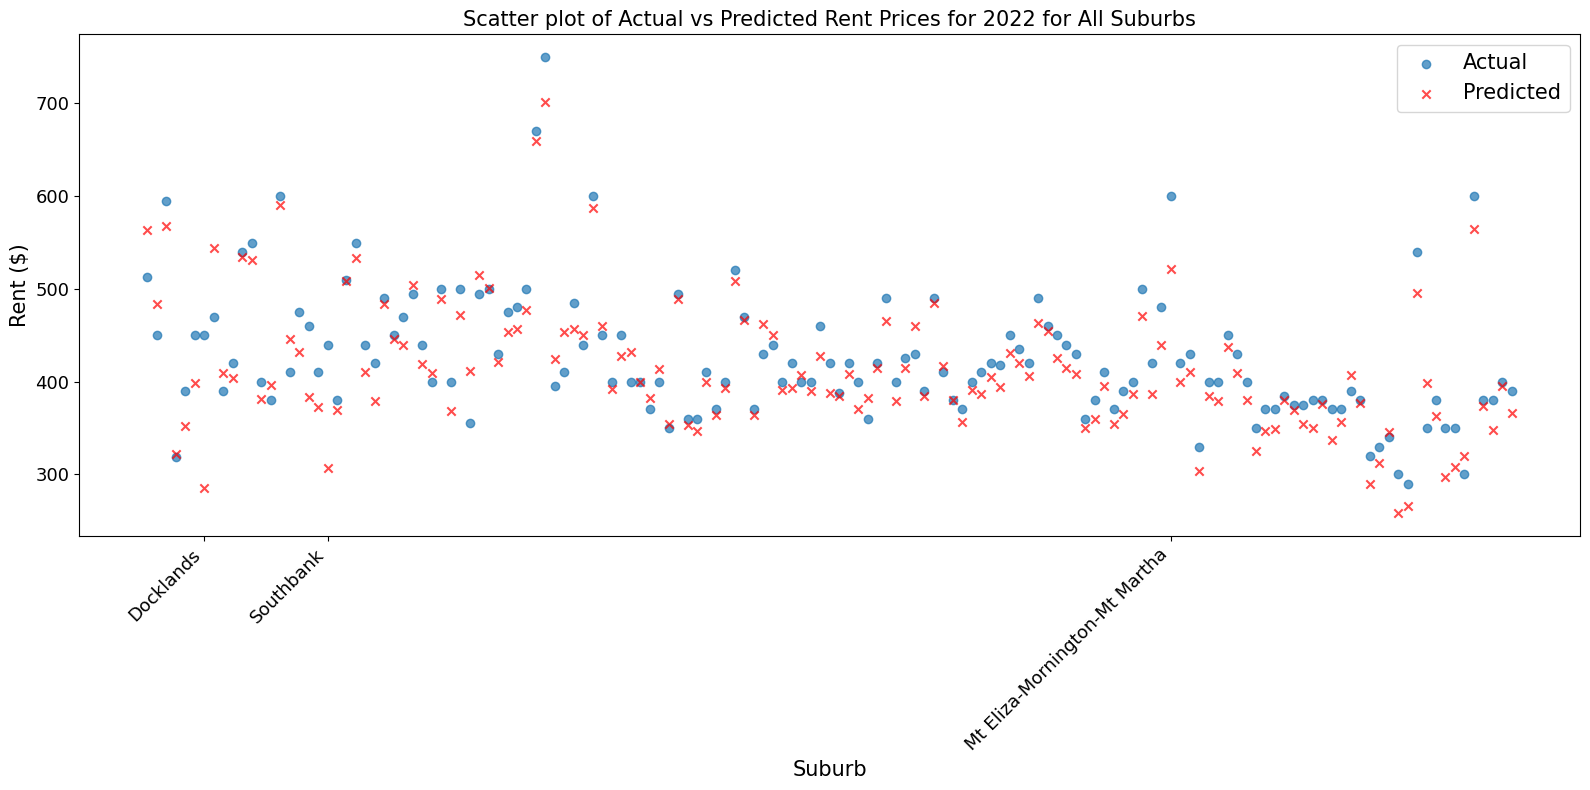

In [21]:
plt.figure(figsize=(16,8))

x = np.arange(len(rent_df_arima))

rent_df_arima['diff'] = abs(rent_df_arima['actual_rent_2022'] - rent_df_arima['predicted_rent_2022'])

plt.scatter(x, rent_df_arima['actual_rent_2022'], label='Actual', marker='o', alpha=0.7)
plt.scatter(x, rent_df_arima['predicted_rent_2022'], label='Predicted', marker='x', color='red', alpha=0.7)

# find the top 3 suburbs that have the largest predicted error
top_suburbs = rent_df_arima.sort_values(by='diff', ascending=False).head(3)

xticks_locs = top_suburbs.index.tolist()
xticks_labels = top_suburbs['suburb'].tolist()

plt.xticks(xticks_locs, xticks_labels, rotation=45, ha='right')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel('Suburb', fontsize = 15)
plt.ylabel('Rent ($)', fontsize = 15)
plt.title('Scatter plot of Actual vs Predicted Rent Prices for 2022 for All Suburbs', fontsize = 15)
plt.legend(fontsize = 15)
plt.tight_layout()

plt.savefig('../plots/Actual_vs_Predicted_Rent_Prices_for_2022_for_All_Suburbs.png')

plt.show()



# predict the rental price in 4 years

In [19]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

forecasts = []

for index, row in merged_df.iterrows():
    suburb = row['suburb']
    
    rents = pd.to_numeric(row[['rent_2018', 'rent_2019', 'rent_2020', 'rent_2021', 'rent_2022']], errors='coerce').dropna()
    
    # If there are non-numeric values, print an error message and continue to the next iteration
    if rents.isnull().any():
        print(f"Non-numeric values found in data for {suburb}, skipping...")
        continue
    
    years = pd.to_datetime(rents.index.str.split('_').str[-1], format='%Y')
    rent_series = pd.Series(rents.values, index=years)
    
    try:
        # ARIMA Model for Rent without using any exogenous variables
        rent_model = ARIMA(rent_series, order=(1, 1, 1))  
        rent_results = rent_model.fit()
        
        rent_forecast = rent_results.get_forecast(steps=4)  # Forecasting 4 steps ahead
        
        forecasts.append({
            'suburb': suburb,
            'forecast_rent_2023': rent_forecast.predicted_mean[0],
            'forecast_rent_2024': rent_forecast.predicted_mean[1],
            'forecast_rent_2025': rent_forecast.predicted_mean[2],
            'forecast_rent_2026': rent_forecast.predicted_mean[3]
        })
        
    except Exception as e:
        print(f"Failed to fit models for {suburb}. Error: {e}")

forecasts_df = pd.DataFrame(forecasts)
forecasts_df


/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/huanhh/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provi

,suburb,forecast_rent_2023,forecast_rent_2024,forecast_rent_2025,forecast_rent_2026
0,Albert Park-Middle Park-West St Kilda,521.729841,523.091273,523.303590,523.336701
1,Armadale,428.664008,449.998542,428.665466,449.997084
2,Carlton North,586.710731,589.232495,588.465323,588.698712
3,Carlton-Parkville,316.535524,316.257208,316.225777,316.222228
4,CBD-St Kilda Rd,401.758560,410.986080,418.227368,423.909964
...,...,...,...,...,...
139,Swan Hill,309.336386,318.671968,328.006745,337.340718
140,Torquay,634.392473,663.215867,687.371966,707.616533
141,Traralgon,411.397370,436.047648,455.400741,470.594979
142,Warragul,417.512116,435.023925,452.535429,470.046626


# Calculating the growth rate
The Compound Annual Growth Rate (CAGR) is calculated using the formula:

$$
\text{CAGR} = \left( \frac{{\text{Ending Value}}}{{\text{Beginning Value}}} \right)^{\frac{{1}}{{n}}} - 1
$$

Where:
- Ending Value is the final value
- Beginning Value is the initial value
- n is the number of years


In [20]:
forecasts_df['growth_rate_2023_2024'] = ((forecasts_df['forecast_rent_2024'] / forecasts_df['forecast_rent_2023']) ** (1/1)) - 1
forecasts_df['growth_rate_2024_2025'] = ((forecasts_df['forecast_rent_2025'] / forecasts_df['forecast_rent_2024']) ** (1/1)) - 1
forecasts_df['growth_rate_2025_2026'] = ((forecasts_df['forecast_rent_2026'] / forecasts_df['forecast_rent_2025']) ** (1/1)) - 1

forecasts_df


,suburb,forecast_rent_2023,forecast_rent_2024,forecast_rent_2025,forecast_rent_2026,growth_rate_2023_2024,growth_rate_2024_2025,growth_rate_2025_2026
0,Albert Park-Middle Park-West St Kilda,521.729841,523.091273,523.303590,523.336701,0.002609,0.000406,0.000063
1,Armadale,428.664008,449.998542,428.665466,449.997084,0.049770,-0.047407,0.049763
2,Carlton North,586.710731,589.232495,588.465323,588.698712,0.004298,-0.001302,0.000397
3,Carlton-Parkville,316.535524,316.257208,316.225777,316.222228,-0.000879,-0.000099,-0.000011
4,CBD-St Kilda Rd,401.758560,410.986080,418.227368,423.909964,0.022968,0.017619,0.013587
...,...,...,...,...,...,...,...,...
139,Swan Hill,309.336386,318.671968,328.006745,337.340718,0.030179,0.029293,0.028457
140,Torquay,634.392473,663.215867,687.371966,707.616533,0.045435,0.036423,0.029452
141,Traralgon,411.397370,436.047648,455.400741,470.594979,0.059918,0.044383,0.033365
142,Warragul,417.512116,435.023925,452.535429,470.046626,0.041943,0.040254,0.038696


In [21]:
# Calculate growth rate from 2023 to 2026
forecasts_df['growth_rate_2023_2026'] = ((forecasts_df['forecast_rent_2026'] / forecasts_df['forecast_rent_2023']) - 1) * 100

# Get top 10 suburbs with the highest growth rate from 2023 to 2026
top_10_suburbs = forecasts_df.nlargest(10, 'growth_rate_2023_2026')

top_10_suburbs[['suburb', 'growth_rate_2023_2026']]


,suburb,growth_rate_2023_2026
133,Morwell,30.844104
136,Sale-Maffra,26.835844
126,Benalla,23.923410
119,Sebastopol-Delacombe,22.261132
143,Wodonga,20.371659
122,Flora Hill-Bendigo East,19.613166
138,Shepparton,19.272195
132,Moe-Newborough,19.249479
107,Hastings-Flinders,18.561291
123,Golden Square-Kangaroo Flat,18.209912


In [23]:
top_rate_suburb = forecasts_df[forecasts_df['suburb'].isin(top_10_suburbs['suburb'])]
top_rate_suburb = top_rate_suburb.iloc[:, :5]
top_rate_suburb['suburb']


107              Hastings-Flinders
119           Sebastopol-Delacombe
122        Flora Hill-Bendigo East
123    Golden Square-Kangaroo Flat
126                        Benalla
132                 Moe-Newborough
133                        Morwell
136                    Sale-Maffra
138                     Shepparton
143                        Wodonga
Name: suburb, dtype: object

# Visualisation

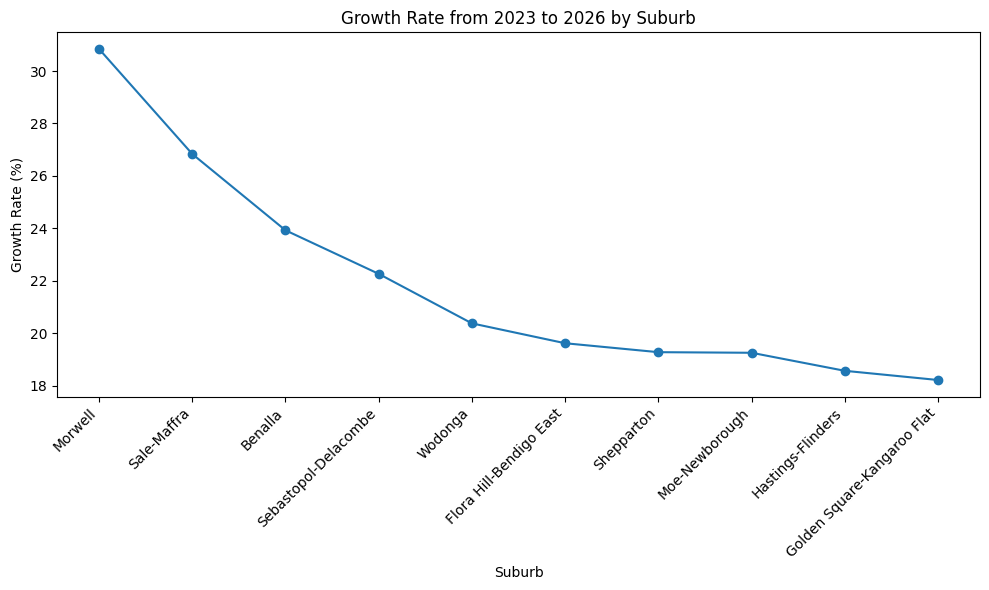

In [27]:

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(top_10_suburbs['suburb'], top_10_suburbs['growth_rate_2023_2026'], marker='o')

# Adding titles and labels
plt.title('Growth Rate from 2023 to 2026 by Suburb')
plt.xlabel('Suburb')
plt.ylabel('Growth Rate (%)')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Displaying the plot
plt.tight_layout()
plt.savefig('../plots/Growth Rate from 2023 to 2026 by Suburb.png')

plt.show()

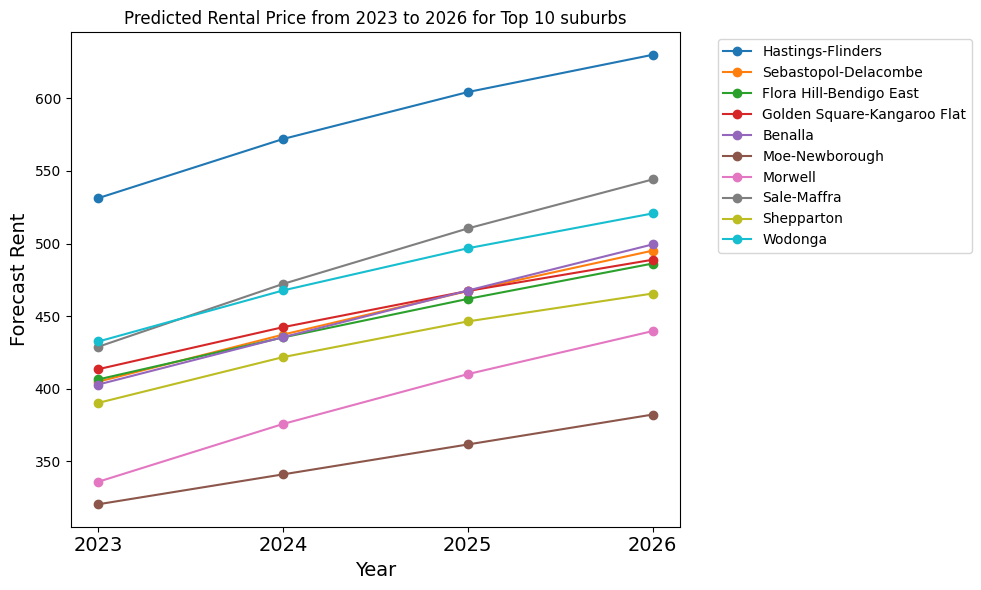

In [8]:


# Melt the DataFrame to long format
df_long = top_rate_suburb.melt(id_vars='suburb', var_name='year', value_name='forecast_rent')

# Extract the year from the 'year' column and convert it to numeric format
df_long['year'] = pd.to_numeric(df_long['year'].str.extract('(\d+)', expand=False))

plt.figure(figsize=(10,6))

# Iterating through unique suburbs in the dataframe to plot the change of predicted rental price
for suburb in df_long['suburb'].unique():
    subset = df_long[df_long['suburb'] == suburb]
    plt.plot('year', 'forecast_rent', data=subset, marker='o', label=suburb)

plt.xticks(df_long['year'].unique(), df_long['year'].unique())
plt.xticks(fontsize = 14)

plt.title('Predicted Rental Price from 2023 to 2026 for Top 10 suburbs')
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Forecast Rent', fontsize = 14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../plots/Predicted_rent_price_for_top_10.png')
plt.show()
